In [161]:
import scipy.io.wavfile as wavfile
import scipy
import scipy.fftpack
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from sklearn import metrics
from math import log2, pow
from scipy.signal import hamming
import itertools as it

In [2]:
def chunkifunci(data, window_size, overlap, f):
    jump = window_size - overlap
    return [f(data[i : i + window_size]) for i in range(0, len(data), jump) if i + window_size <= len(data)]
        
def hps_function(x, numProd, fs, Nfft = None):
    Nfft = x.size

    f = np.arange(Nfft) / Nfft
    xf = scipy.fft(x, Nfft)

    xf = np.abs(xf[f < 0.5])
    f = f[f < 0.5]
    N = f.size

    smallestLength = int(np.ceil(N / numProd))
    y = xf[:smallestLength].copy()
    for i in range(2, numProd + 1):
        y *= xf[::i][:smallestLength]
    f = f[:smallestLength] * fs
    
    amplitudes = y
    frequencies = f
    
    return frequencies, amplitudes

def to_note(f):
    A4 = 440
    C0 = A4*np.power(2, -4.75)
    name = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

    h = round(12*log2(f/C0))
    octave = h // 12
    n = h % 12
    return name[n] + str(octave)

In [17]:
class singer:
    def __init__(self, name, **vocal_range):
        """
        @name: str, name of singer for indexing
        @vocal_range: either tuple of integers (for later classification), or hard-entered str ("S, A, T, B")
        """
        self.name = name 
        if vocal_range:  
            self.vocal_range = vocal_range
        
        #as of right now, these are the only initial inputs I can think of that are necessary to initiliaze
        
    def read(self, file_path):
        """
        @file_path: str, path to audio recording
        """
        self.sampling_rate, self.audio_data = wavfile.read(file_path)
    
    def fft(self, plot = False):

        sample_rate, signal = self.sampling_rate, self.audio_data
        
        self.signal = self.audio_data

        tracks = len(signal.shape)
        if tracks == 2:
            signal = signal.sum(axis=1) / 2
            self.signal = signal

        N = signal.shape[0]

        time_total = N / float(sample_rate)

        time_interval = 1.0/sample_rate 

        t = np.arange(0, time_total, time_interval) 

        FFT_full = abs(scipy.fft(signal)) #"real"-ize the values
        FFT = FFT_full[range(N//2)] #removes unnecessary values from analysis (symmetry)

        freqs_full = scipy.fftpack.fftfreq(signal.size, t[1]-t[0])
        fft_freqs = np.array(freqs_full)

        freqs = freqs_full[range(N//2)] # one side frequency range
        fft_freqs = np.array(freqs)

        if plot == True:
            plt.subplot(211)
            p1 = plt.plot(t, signal, "g") # plotting the signal

            plt.subplot(212)
            p3 = plt.plot(freqs_side, abs(FFT_side), "b") # plotting the positive fft spectrum

            plt.show()

        self.frequencies = fft_freqs
        self.amplitudes = np.array(FFT)

    def fundamental(self, pitch = False):
        #naive fundamental finder
        amps = self.amplitudes
        loc = amps.argmax()
        fundamental = self.frequencies[loc]
        print(fundamental)
        
        if pitch == True:
            print(to_note(fundamental))
            
        self.fundamental = fundamental
    
    def auc_fundamental(self, window_size = 30, overlap = 10, pitch = False):
        areas = []
        freqs_loc = []
        for i in range(0, len(self.frequencies), window_size - overlap):
            x_range = self.frequencies[i: i + window_size]
            y_range = self.amplitudes[i: i + window_size]
            area = metrics.auc(x_range, y_range)
            areas.append(area)
            freqs_loc.append(self.frequencies[i])
        areas = np.array(areas)
        fund_loc = areas.argmax()
        fund = freqs_loc[fund_loc]
        print(fund)
        
        if pitch == True:
            print(to_note(fund))
            
        self.auc_fundamental = fund
        
    def low_fundamental(self, window_size = 30, overlap = 10, tolerance = 0.01, pitch = False):
        areas = []
        freqs_loc = []
        for i in range(0, len(self.frequencies), window_size - overlap):
            x_range = self.frequencies[i: i + window_size]
            y_range = self.amplitudes[i: i + window_size]
            area = metrics.auc(x_range, y_range)
            areas.append(area)
            freqs_loc.append(self.frequencies[i])
        areas = np.array(areas)
        
        total_area = metrics.auc(self.frequencies, self.amplitudes)
        
        limiter = total_area * tolerance
        
        freqs = np.array(freqs_loc)
        
        fund = freqs[np.where(areas > limiter)]
        #fund = freqs_loc[fund_loc]
        print(fund[0])
        
        if pitch == True:
            print(to_note(fund[0]))
            
        self.low_auc_fundamental = fund[0]
         
    def hps(self, window_size = 1024**2, overlap = (1024**2)//2, numProd = 3):
        
        data = self.audio_data
        fs = self.sampling_rate
        
        tracks = len(data.shape)
        if tracks == 2:
            data = data.sum(axis=1) / 2
        
        self.hps = hps_function(data[: window_size], numProd, fs)
        
    def hps_harmonics(self, window_size = 30, overlap = 10, pitch = False):              
        areas = []
        freqs_loc = []

        for i in range(0, len(self.hps[0]), window_size - overlap):
            x_range = self.hps[0][i: i + window_size]
            y_range = self.hps[1][i: i + window_size]
            area = metrics.auc(x_range, y_range)
            areas.append(area)
            freqs_loc.append(self.hps[0][i])

        areas = np.array(areas)

        total_area = metrics.auc(self.hps[0], self.hps[1])

        average = total_area / (self.hps[0][-1] - self.hps[0][0])

        freqs = np.array(freqs_loc)

        fund = freqs[np.where(areas > average)]
        
        self.harmonix = fund
        
    def filter_harmonics(self, tolerance = 2):
        window = scipy.signal.general_gaussian(101, p=1, sig=20)
        filtered = scipy.signal.fftconvolve(window, self.hps[1])
        filtered = (np.average(self.hps[1]) / np.average(filtered)) * filtered
        filtered = np.roll(filtered, -50)
        self.filtered = filtered[:-100]
        
        db = lambda x: np.log10(np.abs(x))
        
        self.log_filtered = db(self.filtered)
        
        freqs = self.hps[0]
        
        indices, _ = scipy.signal.find_peaks(self.log_filtered, prominence = tolerance)
        
        harms = freqs[indices]
        
        self.filharmonix = harms
    
    def audio_model(self):
        powers = self.filtered
        harmonics = self.filharmonix
        
        freq_match = np.logical_not(np.isin(self.hps[0], harmonics))

        powers[np.where(freq_match == True)] = 0
        
        model = scipy.fftpack.ifft(powers)
        self.model_audio = model

In [18]:
JJO = singer("Jakub")
print(JJO.name)
JJO.read("./recordings/vivaldi_.wav")
JJO.fft()
JJO.fundamental()
JJO.auc_fundamental(pitch = True)
JJO.low_fundamental(pitch = True)
JJO.hps()

print()

ARJ = singer("Anthony")
print(ARJ.name)
ARJ.read("./recordings/handel.wav")
ARJ.fft()
ARJ.fundamental()
ARJ.auc_fundamental(pitch = True)
ARJ.low_fundamental(pitch = True)
ARJ.hps()

print()

PJ = singer("Philippe")
print(PJ.name)
PJ.read("./recordings/vivaldi1.wav")
PJ.fft()
PJ.fundamental()
PJ.auc_fundamental(pitch = True)
PJ.low_fundamental(pitch = True)
PJ.hps()

print()

JR = singer("Joe")
print(JR.name)
JR.read("./recordings/rose.wav")
JR.fft()
JR.fundamental()
JR.auc_fundamental(pitch = True)
JR.low_fundamental(pitch = True)
JR.hps()

print()

COH = singer("Christoph")
print(COH.name)
COH.read("./recordings/handel1.wav")
COH.fft()
COH.fundamental()
COH.auc_fundamental(pitch = True)
COH.low_fundamental(pitch = True)
COH.hps()

print()

Jakub
314.91187516557494
314.16386596090615
D#4
299.20368186752967
D4

Anthony
635.8045212765958
633.311170212766
D#5
304.18882978723406
D#4

Philippe
312.171877380837
305.8553005222258
D#4
299.20627225000345
D4

Joe
316.7354918298432
304.28737206360483
D#4
138.3124418470931
C#3

Christoph
669.9723467149805
663.6788404691523
E5
286.0684657194622
D4



In [5]:
db = lambda x: np.log10(np.abs(x))

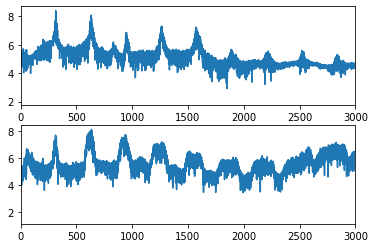

In [6]:
fig = plt.figure()

ax = plt.subplot(211)
ax.plot(JJO.frequencies, db(JJO.amplitudes))

ax.set_xlim(0, 3000)

ax = plt.subplot(212)
ax.plot(ARJ.frequencies, db(ARJ.amplitudes*10))

ax.set_xlim(0, 3000)

plt.show()

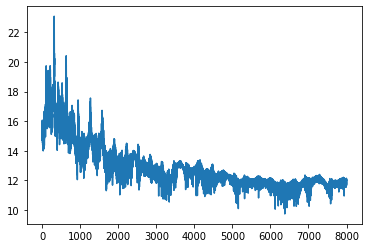

In [7]:
plt.plot(JJO.hps[0], db(JJO.hps[1]))

In [8]:
ARJ.hps_harmonics()

ARJ.harmonix

array([289.2287234 , 294.21542553, 299.20212766, 304.18882979,
       309.17553191, 314.16223404, 319.14893617, 324.1356383 ,
       588.43085106, 593.41755319, 598.40425532, 603.39095745,
       608.37765957, 613.3643617 , 618.35106383, 623.33776596,
       628.32446809, 633.31117021, 638.29787234, 643.28457447,
       648.2712766 , 892.61968085, 897.60638298, 902.59308511,
       907.57978723, 912.56648936, 917.55319149, 922.53989362,
       927.52659574, 932.51329787, 937.5       , 942.48670213,
       947.47340426, 952.46010638, 957.44680851, 962.43351064,
       967.42021277])

array([ 205.20279255,  311.41954787,  637.30053191,  940.24268617,
       1265.87433511, 2700.04986702])

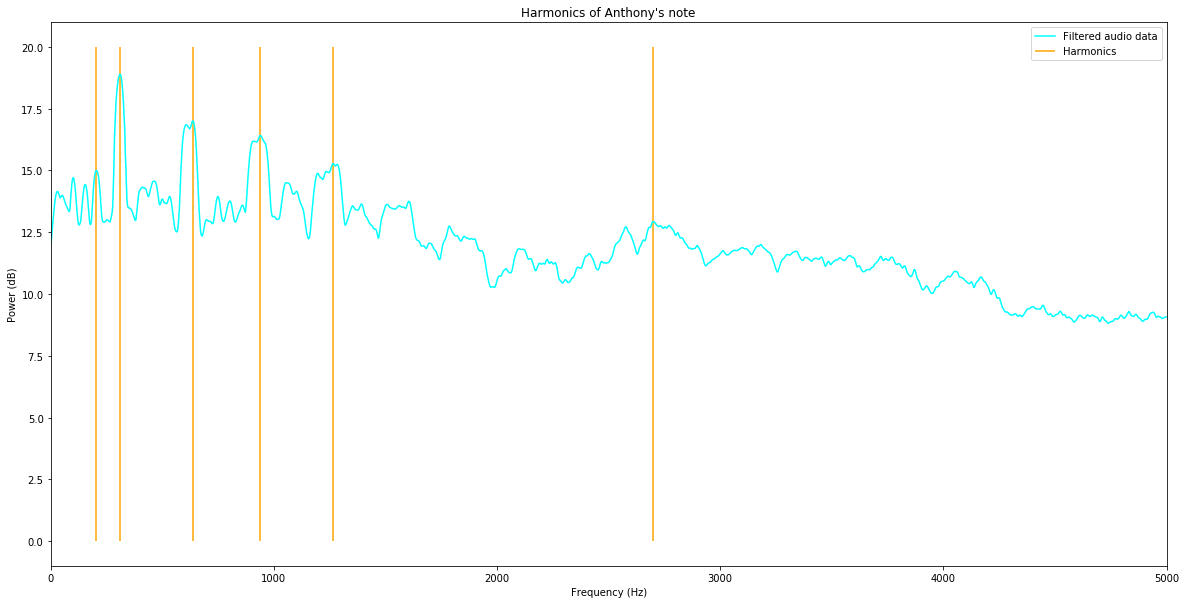

In [62]:
ARJ.filter_harmonics(tolerance = 2)

fig = plt.figure(figsize = (20,10))

plt.plot(ARJ.hps[0], db(ARJ.filtered), color = "cyan", label = "Filtered audio data")
plt.vlines(ARJ.filharmonix, 0, 20, color = 'orange', label = "Harmonics")
plt.title("Harmonics of Anthony's note")
plt.xlim(0,5000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.legend()

ARJ.filharmonix

array([ 211.18793212,  316.15855717,  420.63050943,  631.07043234,
        945.7329711 , 1264.13555589])

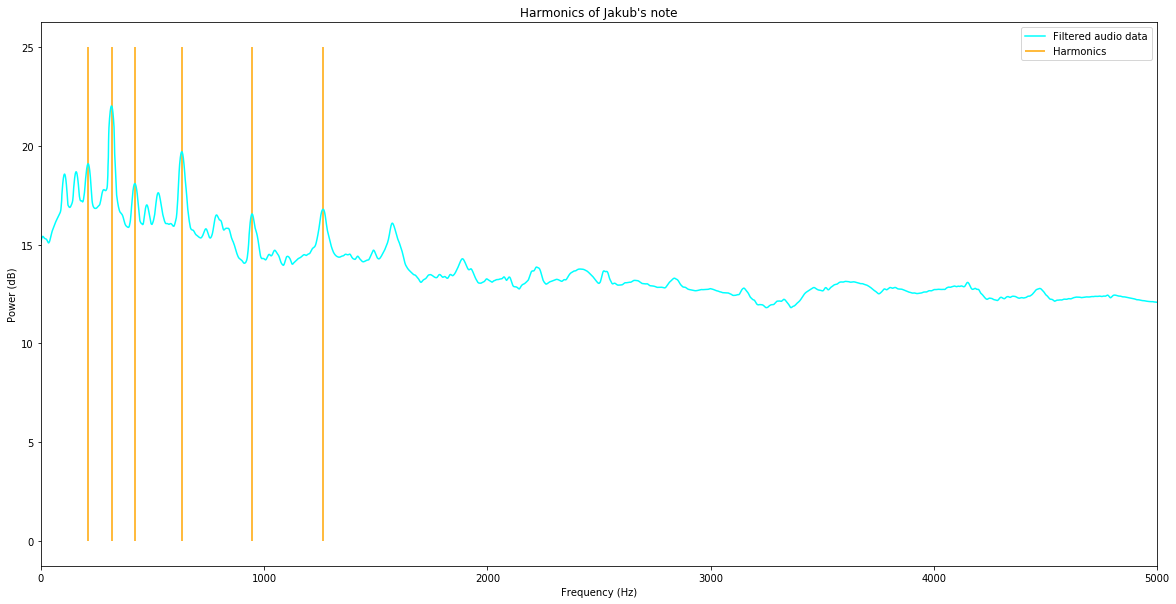

In [61]:
JJO.filter_harmonics(tolerance = 2)

fig = plt.figure(figsize = (20,10))

plt.plot(JJO.hps[0], db(JJO.filtered), color = "cyan", label = "Filtered audio data")
plt.vlines(JJO.filharmonix, 0, 25, color = 'orange', label = "Harmonics")
plt.title("Harmonics of Jakub's note")
plt.xlim(0,5000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.legend()

JJO.filharmonix

In [22]:
JJO.audio_model()
ARJ.audio_model()

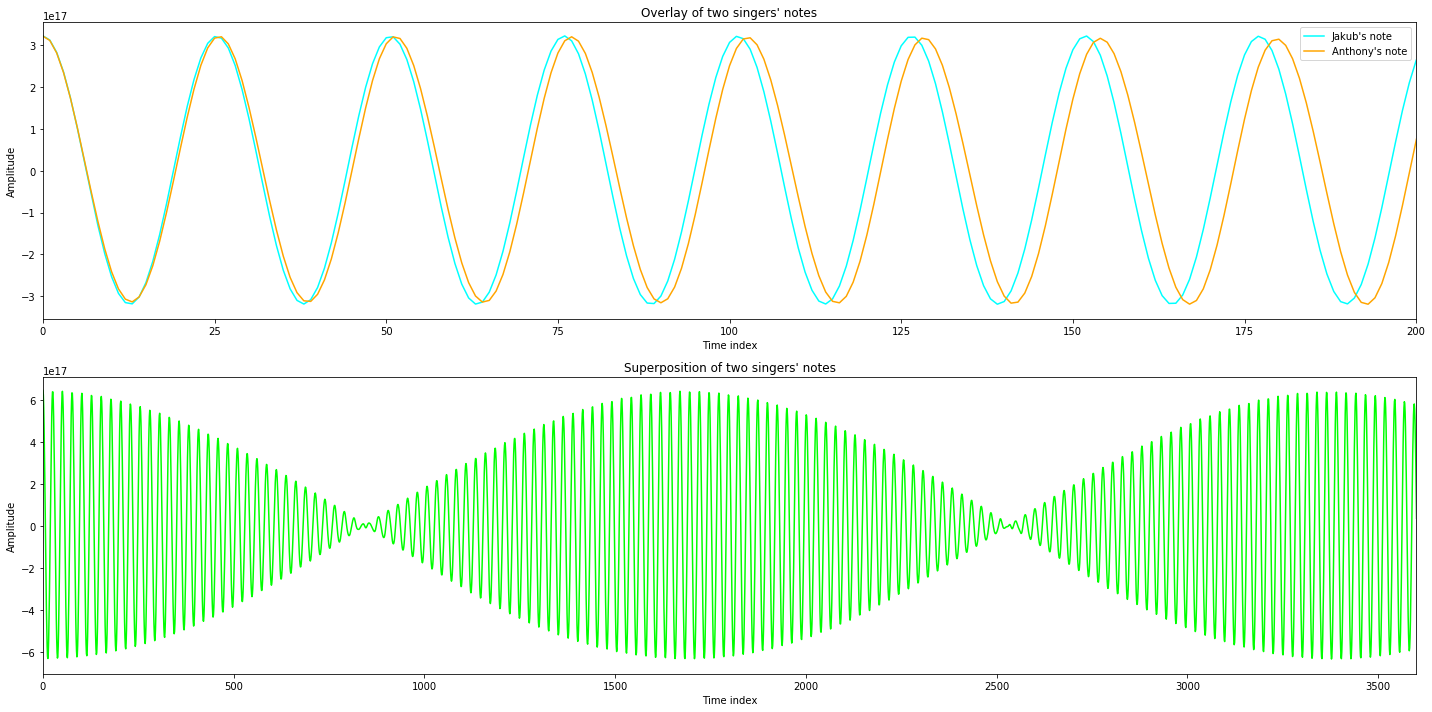

In [60]:
fig = plt.figure(figsize = (20,10))

ax = plt.subplot(211)
ax.set_title("Overlay of two singers' notes")
ax.plot(JJO.model_audio, color = "cyan", label = "Jakub's note")
ax.plot(ARJ.model_audio*1300, color = "orange", label = "Anthony's note")
ax.set_xlim(0, 200)
ax.set_xlabel("Time index")
ax.set_ylabel("Amplitude")
ax.legend()

ax = plt.subplot(212)
ax.set_title("Superposition of two singers' notes")
ax.plot(ARJ.model_audio*1300 + JJO.model_audio, color = "lime")
ax.set_xlabel("Time index")
ax.set_ylabel("Amplitude")
ax.set_xlim(0, 3600)

plt.tight_layout()
plt.show()

In [63]:
PJ.filter_harmonics(tolerance = 2)
JR.filter_harmonics(tolerance = 2)
COH.filter_harmonics(tolerance = 2)

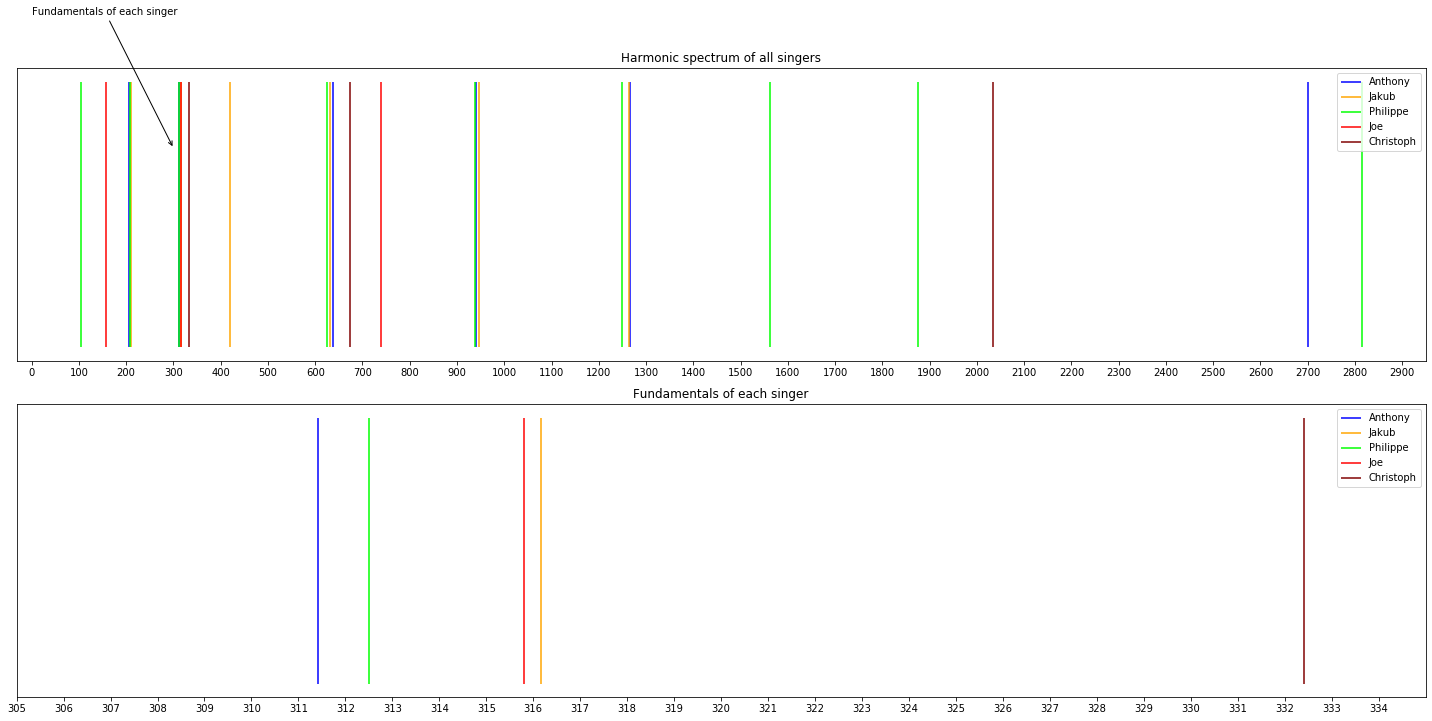

In [115]:
fig = plt.figure(figsize = (20, 10))

ax = plt.subplot(211)

ax.set_title("Harmonic spectrum of all singers")

ax.axes.get_yaxis().set_visible(False)

ax.xaxis.set_ticks(np.arange(0, 3000, 100))

ax.vlines(ARJ.filharmonix, -1, 1, color = 'blue', label = ARJ.name)
ax.vlines(JJO.filharmonix, -1, 1, color = 'orange', label = JJO.name)
ax.vlines(PJ.filharmonix, -1, 1, color = 'lime', label = PJ.name)
ax.vlines(JR.filharmonix, -1, 1, color = 'red', label = JR.name)
ax.vlines(COH.filharmonix, -1, 1, color = 'maroon', label = COH.name)

ax.legend()

ax.annotate("Fundamentals of each singer", xy=(300, 0.5), xytext=(1.5, 1.5), arrowprops=dict(arrowstyle="->"))


ax = plt.subplot(212)

ax.set_title("Fundamentals of each singer")

ax.axes.get_yaxis().set_visible(False)

ax.xaxis.set_ticks(np.arange(305, 335, 1))
ax.set_xlim(305, 335)

ax.vlines(ARJ.filharmonix, -1, 1, color = 'blue', label = ARJ.name)
ax.vlines(JJO.filharmonix, -1, 1, color = 'orange', label = JJO.name)
ax.vlines(PJ.filharmonix, -1, 1, color = 'lime', label = PJ.name)
ax.vlines(JR.filharmonix, -1, 1, color = 'red', label = JR.name)
ax.vlines(COH.filharmonix, -1, 1, color = 'maroon', label = COH.name)

ax.legend()

plt.tight_layout()
plt.show()

In [140]:
def absolute_loss(harmonics1, harmonics2, weights = "increasing"):
    pitch = 311 #Starting pitch such that all calculations line up in starting frequency (less sophisticated)
    
    #starting pitch preprocessing
    
    index1 = np.where(harmonics1 > pitch)[0][0]
    index2 = np.where(harmonics2 > pitch)[0][0]
    
    slice_harm1 = harmonics1[index1:]
    slice_harm2 = harmonics2[index2:]
    
    #zero padding for broadcastability
    
    if len(slice_harm1) > len(slice_harm2):
        slice_harm2 = np.hstack((slice_harm2, np.zeros(len(slice_harm1) - len(slice_harm2))))
    elif len(slice_harm1) < len(slice_harm2):
        slice_harm1 = np.hstack((slice_harm1, np.zeros(len(slice_harm2) - len(slice_harm1))))

    #actual loss calculation
    
    diff = np.subtract(slice_harm1, slice_harm2)
    absdiff = np.abs(diff)
    
    loss = absdiff[np.where(absdiff < 30)]
    
    total_loss = np.sum(absdiff)
    return total_loss

In [143]:
singers = (JJO, ARJ, PJ, JR, COH)

In [164]:
def generate_placements(singers):
    indices = list(range(len(singers)))
    placements = list(it.permutations(indices))
    return placements

In [171]:
def generate_loss_matrix(singers):
    #create loss_matrix
    loss_matrix = []
    for singer in singers:
        loss_list = []
        for partner in singers:
            loss_list.append(absolute_loss(singer.filharmonix, partner.filharmonix))
        loss_matrix.append(loss_list)
    loss_matrix = np.array(loss_matrix)
    return loss_matrix

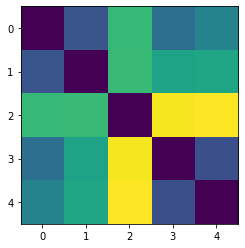

In [159]:
plt.imshow(loss_matrix)

In [187]:
def brute_force(singers):
    #super inefficient
    """Since I'm dealing with such a small "choir," I can rely upon a less efficient algorithm. However, the
    Gale-Shapley algorithm would likely be much more efficient."""
    losses = []
    
    loss_matrix = generate_loss_matrix(singers)
    placements = generate_placements(singers)
    
    for placement in placements:
        sum_loss = 0
        i = 0
        while i < len(placement) - 1:
            index1 = placement[i]
            index2 = placement[i+1]
            sum_loss += loss_matrix[index1][index2]
            i += 1
        losses.append(sum_loss)
    return placements[np.argmin(losses)], losses

In [190]:
brute_force(singers)[0]

(4, 3, 0, 1, 2)

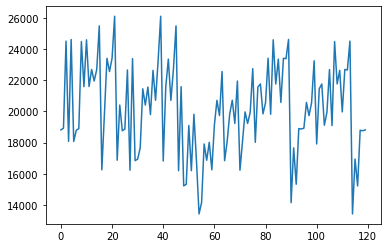

In [191]:
plt.plot(brute_force(singers)[1])